# Prospecção de Dados (Data Mining) DI/FCUL - Project

## Project (MC/DI/FCUL - 2024)

### GROUP:`09`

* Afonso Gama, 55857 - 8 Hours
* Eduardo Carneiro, 62515 - 8 Hours
* Guilherme Rosario, 62543 - 8 Hours
* Marco Viana, 62550 - 8 Hours

In [1]:
import pickle

# Load the fingerprints dataset
with open('../data/mol_bits.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
print(type(data))
print(data)

---

In [2]:
from scipy.sparse import dok_matrix
import numpy as np
import pandas as pd

# Get sparse matrix size from the dataset
height = len(data.keys())
width = max( [max( list(data.values())[i] ) for i in range(height)] )

print(f"Height: {height}, Width: {width}")

# Lookup dictionaries for easier and fast access
mol_name_lookup = {mol_id.strip(" "): idx for idx, mol_id in enumerate(data.keys())}
mol_ids_lookup = {idx: mol_id.strip(" ") for idx, mol_id in enumerate(data.keys())}

# Create the sparse matrix
mat = dok_matrix( (height,width), dtype=np.int32)

# Fill the matrix
for uniprot_idx, (_, struct_ids_list) in zip(range(height), data.items() ):
    for struct_id in struct_ids_list:

        # Indexs are starting from 1 in the dataset
        mat[uniprot_idx, struct_id-1 ] = 1

one_hot_arr = mat.toarray()

df_one_hot_arr = pd.DataFrame(one_hot_arr, index=[mol_ids_lookup[i] for i in range(height)])

Height: 73865, Width: 2047


In [ ]:
print(df_one_hot_arr.head())

In [ ]:
print( type(list(data.keys())[0]) )

In [3]:
import matplotlib.pyplot as plt

# Code from TP05
def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()

# Code from TP05
# THIS IS MODIFIED TO WORK WITH OUR DATA STRUCTURE
def MakeBucketsT(TDocs, perms, N,M, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i==M:                              #this is the case that the document is empty 
                    SIGS[list(L), r]=i                # Highly unlikely in a real data set  
                    L={}
                                                      # we have completed the signature for a given band, 
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

# Code from TP05
# THIS IS MODIFIED TO WORK WITH OUR DATA STRUCTURE
def LSHT(Data, B, R, N,M, NB=28934501 ):
    #transpose the data set
    
    DT=list(Data.values())

    DataT=[set(DT[i]) for i in range(M)]
    P=B*R
    np.random.seed(3)
    #print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms=[np.random.permutation(M) for i in range(P)]
    buckets=MakeBucketsT(DataT, perms, N,M, B,R, NB)
    return buckets

def setify_similarity_results(band, current_dict, list_similar_names):

    for name in list_similar_names:
        for similar_name in list_similar_names:
            
            if similar_name != name:
                if name not in current_dict:
                    current_dict[name] = {band: set()} 
                
                if band not in current_dict[name]:
                    current_dict[name][band] = set()
                    
                current_dict[name][band].add(similar_name)

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc

In [4]:
s=0.7

for band_num in range(10000, 10001, 1000):
    for row_num in range(2, 3):

        p = 1-(1-0.8**row_num)**band_num

        bucks = LSHT(data, band_num, row_num , M = height, N = width)

        # This dict will have a lot of redundancy, but it's easier to search for similar documents of a given document
        results_dict = {}

        for b, buck in bucks:
            if len(bucks[(b,buck)])>1:


                setify_similarity_results(b, results_dict, bucks[(b,buck)])

        # ---

        # Check with Jaccard Sim
        mol_similar = {}
        total_sim = 0
        num_pairs = 0

        for b, buck in bucks:

            if len(bucks[(b,buck)])>1:
                doc_ids=np.array(list(bucks[(b,buck)]))

                idx = np.stack(np.triu_indices(len(doc_ids), k=1), axis=-1)
                sim_pairs=doc_ids[idx]

                for mol1, mol2 in sim_pairs:
                    J=JaccardSim(one_hot_arr[mol1], one_hot_arr[mol2])


                    if J > s: 
                        total_sim += J
                        num_pairs += 1

                        if mol1 not in mol_similar:
                            mol_similar[ mol_ids_lookup[mol1] ] = [ (mol_ids_lookup[mol2],J) ]
                        else:
                            mol_similar[ mol_ids_lookup[mol1] ].append( (mol_ids_lookup[mol2], J) )


        # Sort within each dict entry
        for mol in mol_similar.keys():
            mol_similar[mol] = sorted(mol_similar[mol], key=lambda x: x[1], reverse=True) # tuple contains (mol, sim)


        # Print Jacc Sim above threshold
        print(f"Band: {band_num}, R: {row_num}, P {p} | Mean Jaccard Similarity: {total_sim/num_pairs} | Number of similar pairs: {num_pairs}")

Band: 10000, R: 2, P 1.0 | Mean Jaccard Similarity: 0.7545179303162518 | Number of similar pairs: 15913


---

In [5]:
# Load the data from the csvs
import pandas as pd
import numpy as np
import random

random.seed(42)

df_train_original = pd.read_csv("../data/activity_train.csv", header=None)
df_test = pd.read_csv("../data/activity_test_blanked.csv", header=None)

# Add header
df_train_original.columns = ['Protein_ID', 'Molecule_ID', 'Activity']

num_lines_train = len(df_train_original)

# Merge (Why? In order to not have overlapping mappings in the future)
df_merged = pd.concat([df_train_original, df_test], axis=0, ignore_index=True)


In [ ]:
df_train_original.iloc[0, 1]

In [ ]:
df_merged.iloc[0,1]

In [6]:
# Pre-Processing
from sklearn.preprocessing import LabelEncoder

# Clean the strings
df_merged.iloc[:,0] = df_merged.iloc[:,0].str.strip()
df_merged.iloc[:,1] = df_merged.iloc[:,1].str.strip()

# Get the input arrays from the df
X_full_labels_x1 = df_merged.iloc[:,0].to_numpy()
X_full_labels_x2 = df_merged.iloc[:,1].to_numpy()

# Get unique values for x1
label_enc_x1 = LabelEncoder()
label_enc_x1.fit(X_full_labels_x1)
X_full_transformed_x1 = label_enc_x1.transform(X_full_labels_x1)

# Get unique values for x2
label_enc_x2 = LabelEncoder()
label_enc_x2.fit(X_full_labels_x2)
X_full_transformed_x2 = label_enc_x2.transform(X_full_labels_x2)

# Revert back into train and test
X_train_transformed_x1 = X_full_transformed_x1[:num_lines_train]
X_train_transformed_x2 = X_full_transformed_x2[:num_lines_train]

X_test_transformed_x1 = X_full_transformed_x1[num_lines_train:]
X_test_transformed_x2 = X_full_transformed_x2[num_lines_train:]


# Convert the arrays to dataframe again
df_train_transformed = pd.DataFrame(data = np.column_stack((X_train_transformed_x1, X_train_transformed_x2, df_train_original.iloc[:,2].to_numpy())), columns = [0,1,2])

# Split train into train and validation
train_idxs = random.sample(range(0, num_lines_train), int(num_lines_train * 0.9))

df_train = df_train_transformed.iloc[train_idxs]
df_val = df_train_transformed.drop(train_idxs)


X_train_transformed_x1 = df_train.iloc[:,0].to_numpy()
X_train_transformed_x2 = df_train.iloc[:,1].to_numpy()

X_val_transformed_x1 = df_val.iloc[:,0].to_numpy()
X_val_transformed_x2 = df_val.iloc[:,1].to_numpy()



In [7]:
# Get final inputs for the model
X_train = np.column_stack((X_train_transformed_x1, X_train_transformed_x2))
Y_train = df_train.iloc[:,2].to_numpy()

X_val = np.column_stack((X_val_transformed_x1, X_val_transformed_x2))
Y_val = df_val.iloc[:,2].to_numpy()

X_test = np.column_stack((X_test_transformed_x1, X_test_transformed_x2))

In [28]:
print(np.shape(X_train))

(122139, 2)


In [8]:
# THIS CODE IS ONLY IF WE WANT TO USE THE MOLECULES STRUCTURES TO TRY TO IMPROVE THE MODEL
# Use the molecules structures to see if it helps the model perform better
MAX_SIMILAR_MOLS = 3

# First, add padding to the training matrix to handle more inputs (-1 because it does not correspond to any molecule)
X_train = np.pad( X_train, ((0, 0), (0, MAX_SIMILAR_MOLS)), mode='constant', constant_values=-1)
print(X_train.shape)


# Iterate over the input molecules and check if we have found similar molecules in the LSH
# If we have, we will add the similarity to the input data
mols = list(mol_similar.keys())

X_train_mol_names = X_full_labels_x2[:int(num_lines_train-0.1*num_lines_train)]

success = 0
fail = 0


for idx_train, mol in enumerate(X_train_mol_names):

    # Check if we have found similar molecules
    if mol in mols:

        # Add the similar molecules to the input data
        for i, (mol2, sim) in enumerate(mol_similar[mol]):

            mol2 = mol2.strip(" ")

            if i < MAX_SIMILAR_MOLS:

                # Get the index (mapping) of the molecule
                try:
                    mol2_label = label_enc_x2.transform([mol2])[0]

                    # Put in the input matrix
                    X_train[idx_train][2+i] = mol2_label
                    success += 1

                except Exception as e:
                    # If the molecule is not in the label encoder, we will skip it because it's not present not
                    # in the training or test set
                    if fail < 10:
                        print("Error on mol: ", e)
                    fail += 1
                    continue
            else:
                break


print("Success: ", success)
print("Fail: ", fail)

(122139, 5)
Error on mol:  y contains previously unseen labels: 'CHEMBL2022258'
Error on mol:  y contains previously unseen labels: 'CHEMBL2022258'
Error on mol:  y contains previously unseen labels: 'CHEMBL2047161'
Error on mol:  y contains previously unseen labels: 'CHEMBL2047168'
Error on mol:  y contains previously unseen labels: 'CHEMBL2048623'
Error on mol:  y contains previously unseen labels: 'CHEMBL2047168'
Error on mol:  y contains previously unseen labels: 'CHEMBL4069191'
Error on mol:  y contains previously unseen labels: 'CHEMBL4069191'
Success:  1582
Fail:  8


In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_classifier_model(model, X, Y):
    Y_pred = model.predict(X)
    acc = accuracy_score(Y, Y_pred)
    f1 = f1_score(Y, Y_pred, average="macro")
    precision = precision_score(Y, Y_pred, average="macro", zero_division=0)
    recall = recall_score(Y, Y_pred, average="macro")
    matt = matthews_corrcoef(Y, Y_pred)

    return acc, f1, precision, recall, matt

def print_evaluation_classifier_results(acc, f1, precision, recall, matt, model_name = None):
    print("--------------------")
    if model_name is not None:
        print(f"Results for model: {model_name}")
    print(f"Accuracy: {acc}")
    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Matthews Correlation Coefficient: {matt}")



def evaluate_regression_model(model, X, Y):
    Y_pred = model.predict(X)
    mse = mean_squared_error(Y, Y_pred)
    mae = mean_absolute_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)

    return mse, mae, r2

def print_evaluation_regression_results(mse, mae, r2, model_name = None):
    print("--------------------")
    if model_name is not None:
        print(f"Results for model: {model_name}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")

--------------------
Results for model: RFR with 10 trees
Accuracy: 0.2686413203654583
F1: 0.22783147546761323
Precision: 0.22862142217709583
Recall: 0.2272977114459339
Matthews Correlation Coefficient: 0.16797806257264522
--------------------
Results for model: RFR with 20 trees
Accuracy: 0.26790450928381965
F1: 0.22913213748593017
Precision: 0.22925124066470293
Recall: 0.22906276775208387
Matthews Correlation Coefficient: 0.1684490000738243
--------------------
Results for model: RFR with 30 trees
Accuracy: 0.26702033598585323
F1: 0.22951124325894598
Precision: 0.2297317887303215
Recall: 0.22933228736818118
Matthews Correlation Coefficient: 0.16789927345200556
--------------------
Results for model: RFR with 40 trees
Accuracy: 0.26620984379605067
F1: 0.22880459988099303
Precision: 0.22900863665733867
Recall: 0.2286347703013063
Matthews Correlation Coefficient: 0.16707831328221856
--------------------
Results for model: RFR with 50 trees
Accuracy: 0.2658414382552314
F1: 0.228765402055

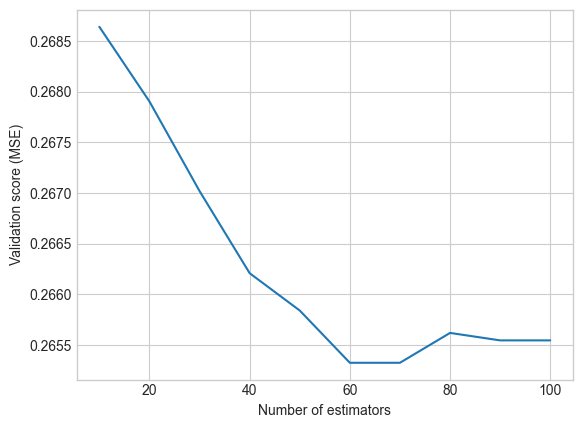

--------------------
Results for model: MLP Classifier with 150 hidden layers
Accuracy: 0.21772767462422635
F1: 0.035763993948562785
Precision: 0.021775976418570375
Recall: 0.1
Matthews Correlation Coefficient: 0.001227062546186254
--------------------
Results for model: MLP Classifier with (200, 100) hidden layers
Accuracy: 0.21772767462422635
F1: 0.035759666001089124
Precision: 0.021772767462422633
Recall: 0.1
Matthews Correlation Coefficient: 0.0
--------------------
Results for model: MLP Classifier with (200, 200) hidden layers
Accuracy: 0.21772767462422635
F1: 0.035759666001089124
Precision: 0.021772767462422633
Recall: 0.1
Matthews Correlation Coefficient: 0.0
--------------------
Results for model: MLP Classifier with (200, 200, 200) hidden layers
Accuracy: 0.21772767462422635
F1: 0.035759666001089124
Precision: 0.021772767462422633
Recall: 0.1
Matthews Correlation Coefficient: 0.0
--------------------
Results for model: MLP Classifier with (200, 200, 300) hidden layers
Accurac

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVC
import copy


import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')


# --- Random Forest Classifier ---
num_estimators = range(10, 110, 10)
val_scores = []
best_model_rf_score = np.inf
best_model_rf = None

# Grid search for the best number of estimators
for i in num_estimators:

    # Train the model
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(X_train, Y_train)

    # Calculate model error on validation set
    metrics = evaluate_classifier_model(model, X_val, Y_val)
    print_evaluation_classifier_results(*metrics, model_name = f"RFR with {i} trees")

    val_scores.append(metrics[0])

    # Save the best model
    if val_scores[-1] < best_model_rf_score:
        best_model_rf_score = val_scores[-1]
        best_model_rf = model

# # Plot the validation scores for each number of estimators
plt.plot(num_estimators, val_scores)
plt.xlabel("Number of estimators")
plt.ylabel("Validation score (MSE)")
plt.show()

# --- MLP Classifier ---
hidden_layer_shapes = [ (150), (200, 100), (200, 200), (200, 200, 200), (200, 200, 300), (200, 250, 300, 150)]

val_scores = []
best_model_score_mlp = 0
best_model_mlp = None
lr = 1e-3


# Grid search for the best number of hidden layers
for layers in hidden_layer_shapes:

        # Train the model
        model = MLPClassifier(hidden_layer_sizes=layers, learning_rate_init=lr, activation="relu", batch_size = 64 , random_state=42)
        model.fit(X_train, Y_train)
    
        # Calculate model error on validation set
        metrics = evaluate_classifier_model(model, X_val, Y_val)
        print_evaluation_classifier_results(*metrics, model_name = f"MLP Classifier with {layers} hidden layers")

        val_scores.append(metrics[0])
    
        # Save the best model
        if val_scores[-1] > best_model_score_mlp:
            best_model_score_mlp = val_scores[-1]
            best_model_mlp = model


In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=100000)
model.fit(X_train, Y_train)

metrics = evaluate_classifier_model(model, X_val, Y_val)
print_evaluation_classifier_results(*metrics, model_name = "Logistic Regression")

--------------------
Results for model: Logistic Regression
Accuracy: 0.21772767462422635
F1: 0.035759666001089124
Precision: 0.021772767462422633
Recall: 0.1
Matthews Correlation Coefficient: 0.0


d:\OneDrive - Universidade de Coimbra\Mestrado\Files\2Semestre\PD\Assignments\1\venv_PD_assign1\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
# Predict
predictions = best_model_rf.predict( np.pad( X_test, ((0, 0), (0, 3) ), mode='constant', constant_values=-1) )

In [33]:
# Save the predictions to a CSV file
df_test.iloc[:, 2] = predictions

df_test.to_csv("PD_PREDS-09.csv", index=False, header=False)